# Time Series Data Standardization

This project revolves around the harmonization of time series data obtained from multiple sensors, characterized by varying sampling rates and temporal discretization. For instance, the project demonstrates this process using datasets from the PDI13215 (pressure sensor) and FI12110 (flow sensor), spanning observations over a period of several months. This project serves as an exemplar of the approach's versatility and can be seamlessly extended to harmonize and standardize datasets from various sensors.

### Tasks

1. #### Adaptive Temporal Data Transformation:


 * Normalize disparate raw data into a standardized forma: Timestamp, PDI13215 Sensor Value, FI12110 Sensor Value
 * Address discrepancies in timestamps and missing values through interpolation, ensuring a consistent N-minute interval (10 minute interval in this example, e.g., 9:00, 9:10, 9:20, etc.). Excessively frequent data points (more frequent than once every N minutes) will be filtered out.


2. #### Data Cleaning and Export:

- Remove rows cointaining empty or NULL values.
- Save the processed data into a `.csv` file encoded in UTF-8, using a comma (`,`) as a delimiter, and timestamp format: `YYYY-MM-DD HH:MI:SS`
- Format the output file similar to the provided template, which serves as a foundation for subsequent machine learning training and analysis:

1: Point name, PDI13215, FI12110  
2: Description, Value for PDI13215, Value for FI12110  
3: Extended Name,  
4: Extended Description,  
5: Units, PSI, M3/h  
6: TIMESTAMP, PDI13215_SENSOR_VALUE, FI12110_SENSOR_VALUE  


<div class="alert alert-block alert-info">
<b>Tip:</b> This project serves as an example of the approach's applicability to PDI13215 and FI12110 data, but it can be readily tailored to handle similar challenges present in data collected from other sensors.
</div>

In [29]:
import pandas as pd
import numpy as np
import pyodbc
from datetime import datetime
import seaborn as sns
import os
import matplotlib.pyplot as plt

In [2]:
current_directory = os.getcwd()

<b>Table_name_1:</b> FI12110_1 <br>
<b>Columns:</b> Time Status Source Value <br>
<b>Table_name_2:</b> PDI13215 <br>
<b>Columns:</b> Time Source Value <br>

#### Reading data from SQL databases

In [3]:
path1 = current_directory+'\\FI12110.accdb'
path2 =  current_directory+'\\PDI13215.accdb'

In [33]:
conn = pyodbc.connect(f'Driver={{Microsoft Access Driver (*.mdb, *.accdb)}};DBQ={path1};')

In [34]:
FI12110 = pd.read_sql_query('select Time, Value from FI12110_1 WHERE Time IS NOT NULL AND Value IS NOT NULL', parse_dates = {'Time':'%Y%m%d %H:%M:%S'}, con = conn)

C:\Users\pauli\AppData\Local\Temp\ipykernel_16308\2051993357.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  FI12110 = pd.read_sql_query('select Time, Value from FI12110_1', parse_dates = {'Time':'%Y%m%d %H:%M:%S'}, con = conn)


In [8]:
conn.close()

In [37]:
conn = pyodbc.connect(f'Driver={{Microsoft Access Driver (*.mdb, *.accdb)}};DBQ={path2};')

In [38]:
PDI13215 = pd.read_sql_query('select Time, Value from PDI13215', parse_dates = {'Time':'%Y%m%d %H:%M:%S'}, con = conn)

C:\Users\pauli\AppData\Local\Temp\ipykernel_16308\2213405838.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  PDI13215 = pd.read_sql_query('select Time, Value from PDI13215', parse_dates = {'Time':'%Y%m%d %H:%M:%S'}, con = conn)


In [39]:
conn.close()

In [22]:
FI12110.shape

(13281216, 2)

In [24]:
PDI13215.shape

(12439496, 2)

In [67]:
FI12110.head()

,Time,Value
0,2019-10-01 09:00:01,503.131744
1,2019-10-01 09:00:27,507.307098
2,2019-10-01 09:00:28,503.131744
3,2019-10-01 09:00:30,507.307098
4,2019-10-01 09:00:31,503.131744


In [64]:
PDI13215.head()

,Time,Value
0,2019-10-01 00:15:25,70.0
1,2019-10-01 01:15:25,70.0
2,2019-10-01 02:15:26,70.0
3,2019-10-01 03:15:26,70.0
4,2019-10-01 04:15:27,70.0


#### Performing a merge operation between several DataFrames

Parameter how='outer' specifies that it's performing an outer join, which includes all rows from both DataFrames, merging where there are matching 'Time' values and filling in missing values with NaN (missing values).

In [41]:
df = FI12110.merge(PDI13215, how='outer', on='Time')

In [42]:
# Reassigning column names to the DataFrame
df = df.sort_values(by="Time").reset_index(drop = True)
df.columns = ['Time', 'FI12110', 'PDI13215']

In [65]:
df.head()

,Time,FI12110,PDI13215
0,2019-10-01 00:15:25,NaN,70.0
1,2019-10-01 01:15:25,NaN,70.0
2,2019-10-01 02:15:26,NaN,70.0
3,2019-10-01 03:15:26,NaN,70.0
4,2019-10-01 04:15:27,NaN,70.0


#### Creating a heatmap representing null (missing) values in the DataFrame

<Axes: >

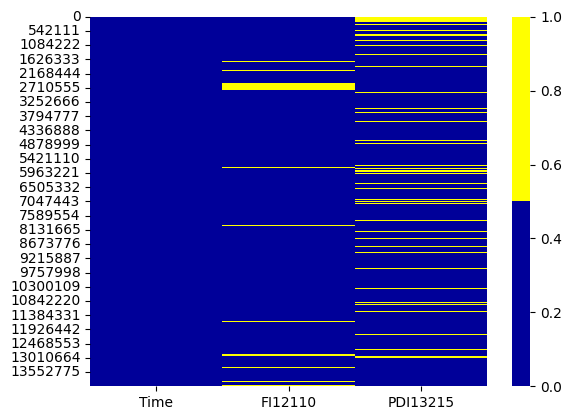

In [31]:
colours = ['#000099', '#ffff00'] 
sns.heatmap(df[df.columns].isnull(), cmap=sns.color_palette(colours))

In [43]:
df.shape

(14094870, 3)

In [44]:
df.head()

,Time,FI12110,PDI13215
0,2019-10-01 00:15:25,NaN,70.0
1,2019-10-01 01:15:25,NaN,70.0
2,2019-10-01 02:15:26,NaN,70.0
3,2019-10-01 03:15:26,NaN,70.0
4,2019-10-01 04:15:27,NaN,70.0


#### Replacing duplicates by their mean values, converting dataframes to series

In [78]:
FI12110 = FI12110.groupby('Time').mean().reset_index()

In [80]:
FI12110.head()

,Time,Value
0,2019-10-01 09:00:01,503.131744
1,2019-10-01 09:00:27,507.307098
2,2019-10-01 09:00:28,503.131744
3,2019-10-01 09:00:30,507.307098
4,2019-10-01 09:00:31,503.131744


In [95]:
FI = pd.Series(FI12110['Value'].values, index=FI12110['Time'].values)

In [49]:
PDI13215 = PDI13215.groupby('Time').mean().reset_index()

In [81]:
PDI13215.head()

,Time,Value
0,2019-10-01 00:15:25,70.0
1,2019-10-01 01:15:25,70.0
2,2019-10-01 02:15:26,70.0
3,2019-10-01 03:15:26,70.0
4,2019-10-01 04:15:27,70.0


In [51]:
PDI = pd.Series(PDI13215['Value'].values, index=PDI13215['Time'])

In [127]:
FI.head(10)

2019-10-01 09:00:01    503.131744
2019-10-01 09:00:27    507.307098
2019-10-01 09:00:28    503.131744
2019-10-01 09:00:30    507.307098
2019-10-01 09:00:31    503.131744
2019-10-01 09:00:34    507.307098
2019-10-01 09:00:37    503.131744
2019-10-01 09:00:39    507.307098
2019-10-01 09:00:40    503.131744
2019-10-01 09:00:48    507.307098
dtype: float64

In [92]:
PDI.head(10)

Time
2019-10-01 00:15:25    70.0
2019-10-01 01:15:25    70.0
2019-10-01 02:15:26    70.0
2019-10-01 03:15:26    70.0
2019-10-01 04:15:27    70.0
2019-10-01 05:15:27    70.0
2019-10-01 06:15:27    70.0
2019-10-01 07:15:28    70.0
2019-10-01 08:15:29    70.0
2019-10-01 09:15:29    70.0
dtype: float64

#### Resampling and interpolation

By using .nearest() first, you're filling the gaps by grabbing the nearest available value before proceeding with .interpolate(), which performs an interpolation between the filled points.  
This approach is beneficial because .nearest() fills in the missing values by selecting the nearest known data point, and then .interpolate() smooths the data between these filled points, potentially providing a more accurate estimation of the missing values.  
Adjust the method and parameters of the interpolation (_like cubic, polynomial, etc._) based on the characteristics of your data to achieve the best estimation between known data points while ensuring that the initial NaN values are adequately handled.